<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Sebastian Raschka의 도서 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>를 위한 보조 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 4장: 텍스트 생성을 위한 GPT 모델 직접 구현

In [12]:
from importlib.metadata import version

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.7
torch version: 2.9.0
tiktoken version: 0.12.0


- 이번 장에서는 GPT와 유사한 LLM 아키텍처를 구현하고, 다음 장에서는 이 LLM 학습에 집중합니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

## 4.1 LLM 아키텍처 코딩하기

- 1장에서는 GPT와 Llama 같은 모델이 원래 트랜스포머 구조의 디코더 부분을 기반으로 하여 단어를 순차적으로 생성한다고 설명했습니다
- 따라서 이러한 LLM을 흔히 "디코더 기반" LLM이라고 부릅니다
- 전통적인 딥러닝 모델과 달리 LLM이 거대한 이유는 코드 양이 아니라 방대한 파라미터 수 때문입니다
- LLM 아키텍처에서는 동일한 구성 요소가 여러 번 반복되는 모습을 자주 보게 될 것입니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="800px">

- 앞 장들에서는 설명을 쉽게 하기 위해 입력과 출력 토큰의 임베딩 차원을 작게 설정해 도식이 한 페이지에 들어가도록 했습니다
- 이번 장에서는 소형 GPT-2 모델에 가까운 임베딩과 모델 크기를 다룹니다
- Radford 등의 [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) 논문에 제시된 가장 작은 GPT-2 모델(파라미터 1억 2,400만 개)의 아키텍처를 직접 구현합니다. (초기 보고에는 1억 1,700만 개라고 적혀 있었지만, 이후 모델 가중치 저장소에서 수정되었습니다.)
- 6장에서는 본 구현에 사전 학습된 가중치를 불러오는 방법을 다루며, 345M·762M·1542M 파라미터 모델 크기와도 호환될 예정입니다

- 1억 2,400만 개 파라미터를 가진 GPT-2 모델의 구성은 다음과 같습니다:

In [13]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘 크기
    "context_length": 1024, # 컨텍스트 길이
    "emb_dim": 768,         # 임베딩 차원
    "n_heads": 12,          # 어텐션 헤드 수
    "n_layers": 12,         # 레이어 개수
    "drop_rate": 0.1,       # 드롭아웃 비율
    "qkv_bias": False       # 쿼리·키·밸류 바이어스 사용 여부
}

- 이후 코드가 길어지는 것을 막기 위해 변수 이름을 짧게 사용합니다
- `"vocab_size"`는 2장에서 다룬 BPE 토크나이저가 지원하는 50,257개 어휘 크기를 의미합니다
- `"context_length"`는 2장에서 소개한 위치 임베딩 덕분에 모델이 한 번에 처리할 수 있는 최대 입력 토큰 수를 뜻합니다
- `"emb_dim"`은 각 입력 토큰을 768차원 벡터로 변환하는 임베딩 크기입니다
- `"n_heads"`는 3장에서 구현한 멀티헤드 어텐션의 헤드 개수입니다
- `"n_layers"`는 모델 안에 있는 트랜스포머 블록 개수이며, 다음 절에서 구현합니다
- `"drop_rate"`는 3장에서 다룬 드롭아웃의 강도를 뜻하며, 0.1은 학습 중 은닉 유닛의 10%를 꺼 과적합을 줄인다는 의미입니다
- `"qkv_bias"`는 3장에서 구현한 멀티헤드 어텐션의 `Linear` 계층이 쿼리(Q)·키(K)·밸류(V) 텐서를 계산할 때 바이어스 벡터를 사용할지 여부를 결정합니다. 현대 LLM에서는 보통 비활성화하며, 5장에서 OpenAI의 GPT-2 사전 학습 가중치를 불러올 때 다시 살펴보겠습니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="800px">

In [ ]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 토큰 임베딩 계층: 각 토큰을 emb_dim 차원의 벡터로 변환
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # 위치 임베딩 계층: 각 위치를 emb_dim 차원의 벡터로 변환
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # 드롭아웃 계층: 과적합 방지를 위해 일부 뉴런을 비활성화
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # n_layers개의 트랜스포머 블록을 순차적으로 연결
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # 최종 정규화 계층
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        # 출력 헤드: 임베딩을 vocab_size 크기의 로짓으로 변환
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # 입력 텐서의 배치 크기와 시퀀스 길이를 가져옴
        batch_size, seq_len = in_idx.shape
        # 토큰 임베딩 계산
        tok_embeds = self.tok_emb(in_idx)
        # 위치 임베딩 계산 (0부터 seq_len-1까지의 위치)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # 토큰 임베딩과 위치 임베딩을 더함
        x = tok_embeds + pos_embeds
        # 드롭아웃 적용
        x = self.drop_emb(x)
        # 트랜스포머 블록들을 통과
        x = self.trf_blocks(x)
        # 최종 정규화 적용
        x = self.final_norm(x)
        # 출력 로짓 계산
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 실제 구현은 나중에 할 예정인 더미 트랜스포머 블록

    def forward(self, x):
        # 현재는 입력을 그대로 출력하는 패스스루 구현
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # 실제 LayerNorm 구현을 위한 인터페이스 파라미터

    def forward(self, x):
        # 현재는 입력을 그대로 출력하는 패스스루 구현
        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="800px">

In [ ]:
# tiktoken 라이브러리를 임포트합니다
import tiktoken

# GPT-2 토크나이저를 가져옵니다
tokenizer = tiktoken.get_encoding("gpt2")

# 배치를 저장할 빈 리스트를 생성합니다
batch = []

# 토큰화할 두 개의 텍스트 문장을 정의합니다
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

# 각 문장을 토큰화하고 텐서로 변환하여 배치에 추가합니다
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))

# 배치의 텐서들을 하나의 2D 텐서로 쌓습니다
batch = torch.stack(batch, dim=0)

# 결과 배치 텐서를 출력합니다
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [ ]:
# 재현성을 위해 난수 시드를 설정합니다
torch.manual_seed(123)

# 124M 파라미터 설정으로 더미 GPT 모델을 초기화합니다
model = DummyGPTModel(GPT_CONFIG_124M)

# 배치를 모델에 통과시켜 로짓을 얻습니다
logits = model(batch)

# 출력 텐서의 형태와 값을 출력합니다
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


---

**노트**

- Windows나 Linux에서 이 코드를 실행하면 아래와 같은 값이 출력될 수 있습니다:

```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- 무작위 값일 뿐이므로 걱정하지 않아도 되며, 이어지는 내용을 그대로 진행하면 됩니다
- 이런 차이는 PyTorch 컴파일 방식에 따라 운영체제별로 `nn.Dropout`의 동작이 달라서 발생할 수 있으며, 자세한 내용은 [PyTorch 이슈 트래커](https://github.com/pytorch/pytorch/issues/121595)에서 확인할 수 있습니다

---

## 4.2 레이어 정규화를 이용한 활성값 정규화

- 레이어 정규화(레이어노름, [Ba et al. 2016](https://arxiv.org/abs/1607.06450))는 신경망 층의 활성값을 평균 0, 분산 1로 맞춥니다
- 이를 통해 학습이 안정되고 효과적인 가중치에 더 빠르게 수렴할 수 있습니다
- 레이어 정규화는 이후 구현할 트랜스포머 블록에서 멀티헤드 어텐션 모듈 앞뒤에 적용되며, 최종 출력층 앞에서도 사용됩니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="800px">

- 작은 입력 예시를 간단한 신경망 층에 통과시켜 레이어 정규화가 어떻게 동작하는지 살펴보겠습니다

In [17]:
torch.manual_seed(123)

# 특성 5개를 가진 학습 예시 2개 생성
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


- 위의 두 입력 각각에 대해 평균과 분산을 계산해 봅시다

In [18]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- 정규화는 두 입력(각 행)에 독립적으로 적용됩니다. `dim=-1`을 사용하면 행 차원 대신 마지막 차원(여기서는 특성 차원)을 따라 계산합니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="800px">

- 평균을 빼고 분산(표준편차의 제곱근)으로 나누면 열(특성) 차원에서 평균 0, 분산 1이 되도록 값을 가운데 맞출 수 있습니다

In [ ]:
# 평균을 빼고 분산의 제곱근으로 나누어 정규화
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

# 정규화된 출력의 평균과 분산 계산
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 각 입력은 평균 0, 분산 1로 정규화됩니다. 가독성을 위해 PyTorch의 과학적 표기법을 끌 수 있습니다

In [20]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 위에서는 각 입력의 특성을 정규화했습니다
- 같은 아이디어로 `LayerNorm` 클래스를 직접 구현해 보겠습니다

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        """
        레이어 정규화를 수행하는 클래스
        
        Args:
            emb_dim: 임베딩 차원 크기
        """
        super().__init__()
        self.eps = 1e-5  # 0으로 나누는 것을 방지하기 위한 작은 값
        self.scale = nn.Parameter(torch.ones(emb_dim))  # 학습 가능한 스케일 파라미터
        self.shift = nn.Parameter(torch.zeros(emb_dim))  # 학습 가능한 시프트 파라미터

    def forward(self, x):
        """
        입력 텐서에 레이어 정규화를 적용
        
        Args:
            x: 입력 텐서
            
        Returns:
            정규화된 출력 텐서
        """
        mean = x.mean(dim=-1, keepdim=True)  # 마지막 차원의 평균 계산
        var = x.var(dim=-1, keepdim=True, unbiased=False)  # 편향된 분산 계산
        norm_x = (x - mean) / torch.sqrt(var + self.eps)  # 정규화 수행
        return self.scale * norm_x + self.shift  # 스케일과 시프트 적용

**스케일과 시프트**

- 평균을 빼고 분산으로 나누는 정규화 외에 `scale`과 `shift`라는 두 개의 학습 가능한 파라미터를 추가했습니다
- 초기값 `scale`=1, `shift`=0은 출력에 영향을 주지 않지만, 학습 과정에서 LLM이 필요하다고 판단하면 이 값을 조정해 성능을 높일 수 있습니다
- 즉, 모델이 데이터에 가장 알맞은 스케일링과 시프트를 학습할 수 있게 해 줍니다
- 또한 분산이 0일 때 0으로 나누는 오류를 피하려고 제곱근을 계산하기 전에 작은 값(`eps`)을 더합니다

**편향된 분산(biased variance)**

- 위 분산 계산에서 `unbiased=False`로 두면 표본 크기 n(여기서는 특성 수 또는 열 수)을 분모로 사용하는 $\frac{\sum_i (x_i - \bar{x})^2}{n}$ 공식을 사용하게 됩니다. 이는 분모에 `n-1`을 쓰는 벨셀 보정을 적용하지 않으므로 분산의 편향 추정치를 제공합니다 
- LLM처럼 임베딩 차원 `n`이 매우 큰 경우 `n`과 `n-1`의 차이는 사실상 무시할 수 있습니다
- GPT-2도 정규화 층에서 편향된 분산을 사용했기 때문에, 이후 장에서 불러올 사전 학습 가중치와 호환되도록 동일한 설정을 채택했습니다


이제 `LayerNorm`을 직접 활용해 보겠습니다:

In [22]:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)

In [23]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="800px">

## 4.3 GELU 활성화를 사용하는 피드포워드 네트워크 구현

- 이번 절에서는 LLM의 트랜스포머 블록에서 사용되는 작은 신경망 하위 모듈을 구현합니다
- 먼저 활성 함수부터 살펴보겠습니다
- 딥러닝에서는 구조가 단순하고 다양한 아키텍처에서 효과적인 ReLU(정류 선형 유닛) 활성 함수를 자주 사용합니다
- LLM에서는 전통적인 ReLU 외에도 여러 활성 함수를 사용하며, 대표적으로 GELU(Gaussian Error Linear Unit)와 SwiGLU(Swish-Gated Linear Unit)가 있습니다
- GELU와 SwiGLU는 각각 가우시안·시그모이드 게이팅을 결합한 매끄러운 활성 함수로, 구간별 선형 함수인 ReLU보다 깊은 모델에서 더 좋은 성능을 내는 경우가 많습니다

- GELU([Hendrycks and Gimpel 2016](https://arxiv.org/abs/1606.08415))는 여러 방식으로 구현할 수 있으며, 정확한 정의는 GELU(x)=x⋅Φ(x)입니다. 여기서 Φ(x)는 표준 가우시안 분포의 누적분포함수(CDF)입니다.
- 실제 구현에서는 더 계산이 간단한 근사식을 사용하는 경우가 많습니다. 예를 들어 $\mathrm{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)$ 을 사용하며, 원래 GPT-2 모델도 이 근사식을 이용해 학습되었습니다.

In [ ]:
# GELU 근사식 활성 함수 (GPT-2 등에서 사용한 공식)
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # 0.5 * x * (1 + tanh( sqrt(2/pi) * (x + 0.044715 * x^3) ))
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

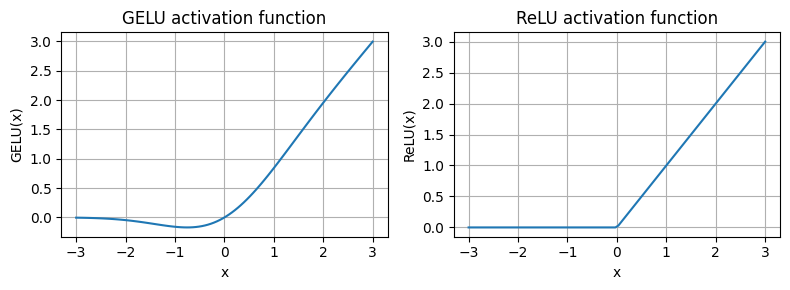

In [25]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# 예시 데이터
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- ReLU는 입력이 양수이면 그대로 출력하고, 음수이면 0을 출력하는 구간별 선형 함수입니다
- GELU는 음수 영역에서도 (약 -0.75 지점을 제외하고) 0이 아닌 기울기를 유지하는 매끄러운 비선형 함수로, ReLU를 부드럽게 근사합니다

이제 트랜스포머 블록에서 사용할 작은 신경망 모듈 `FeedForward`를 구현해 보겠습니다:

In [ ]:
# FeedForward 모듈은 트랜스포머 블록 내에서 사용되는 작은 신경망입니다.
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 입력 차원에서 4배 확장 후 다시 원래 차원으로 축소하는 두 개의 선형 계층과 GELU 활성화 함수로 구성됩니다.
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),  # 첫 번째 선형 계층: emb_dim → 4*emb_dim
            GELU(),                                         # GELU 활성 함수 적용
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),  # 두 번째 선형 계층: 4*emb_dim → emb_dim
        )

    def forward(self, x):
        # 입력 x를 순차적으로 layers에 통과시킵니다.
        return self.layers(x)

In [27]:
print(GPT_CONFIG_124M["emb_dim"])

768


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="800px">

In [28]:
ffn = FeedForward(GPT_CONFIG_124M)

# 입력 형태: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="800px">

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="800px">

## 4.4 쇼트컷(스킵) 연결 추가하기

- 이제 쇼트컷 연결(스킵 또는 잔차 연결)의 개념을 살펴보겠습니다
- 원래는 컴퓨터 비전을 위한 깊은 신경망(ResNet)에서 기울기 소실 문제를 줄이기 위해 제안되었습니다
- 쇼트컷 연결은 기울기가 네트워크를 더 수월하게 통과할 수 있도록 짧은 경로를 제공합니다
- 이를 위해 한 층의 출력을 이후 층의 출력에 더하면서, 그 사이의 한두 층을 건너뜁니다
- 아래 작은 예제 네트워크로 이 아이디어를 그림으로 살펴보겠습니다:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="800px">

- 코드로 표현하면 다음과 같습니다:

In [ ]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        # 각 층을 nn.ModuleList에 저장합니다.
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),  # 1번째 층
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),  # 2번째 층
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),  # 3번째 층
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),  # 4번째 층
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())   # 5번째 층
        ])

    def forward(self, x):
        # 입력을 각 층에 순차적으로 통과시킵니다.
        for layer in self.layers:
            layer_output = layer(x)  # 현재 층의 출력
            # 입력 x와 layer_output의 shape이 같으면 쇼트컷 연결을 적용합니다.
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output  # 쇼트컷 연결(잔차 연결)
            else:
                x = layer_output     # 그냥 출력 사용
        return x


def print_gradients(model, x):
    # 모델의 순전파를 실행합니다.
    output = model(x)
    target = torch.tensor([[0.]])

    # 출력과 타깃의 차이를 기준으로 MSE 손실을 계산합니다.
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # 역전파를 통해 각 가중치에 대한 기울기를 계산합니다.
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # 각 가중치의 기울기 절댓값 평균을 출력합니다.
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

- 먼저 쇼트컷 연결이 **없는** 경우의 기울기 값을 출력해 보겠습니다:

In [ ]:
# 각 층별 뉴런 수를 정의합니다.
layer_sizes = [3, 3, 3, 3, 3, 1]  

# 샘플 입력값을 만듭니다.
sample_input = torch.tensor([[1., 0., -1.]])

# 동일한 가중치 초기화를 위해 시드 고정
torch.manual_seed(123)
# 쇼트컷 연결이 없는 모델 생성
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
# 각 층의 기울기(gradient) 평균값 출력
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


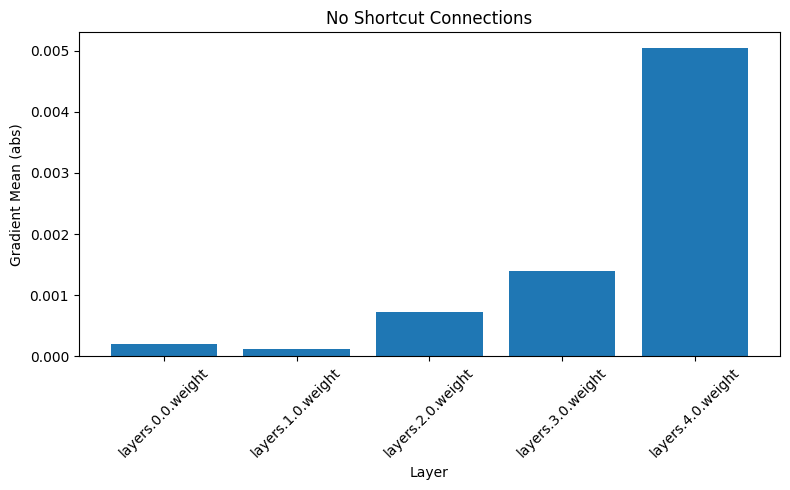

In [ ]:
import matplotlib.pyplot as plt

# gradient 값 시각화를 위한 함수
def plot_gradients(model, title="Gradient Means per Layer"):
    grad_means = []
    layer_names = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            grad_means.append(param.grad.abs().mean().item())
            layer_names.append(name)
    plt.figure(figsize=(8, 5))
    plt.bar(layer_names, grad_means)
    plt.ylabel('Gradient Mean (abs)')
    plt.xlabel('Layer')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 기울기 시각화 (쇼트컷 없는 모델)
plot_gradients(model_without_shortcut, title="No Shortcut Connections")

- 다음으로 쇼트컷 연결이 **있는** 경우의 기울기 값을 확인해 보겠습니다:

In [ ]:
# 동일한 가중치 초기화를 위해 시드 고정
torch.manual_seed(123)
# 쇼트컷 연결이 있는 모델 생성
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
# 각 층의 기울기(gradient) 평균값 출력
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169798612594604
layers.1.0.weight has gradient mean of 0.20694111287593842
layers.2.0.weight has gradient mean of 0.3289700150489807
layers.3.0.weight has gradient mean of 0.26657330989837646
layers.4.0.weight has gradient mean of 1.3258544206619263


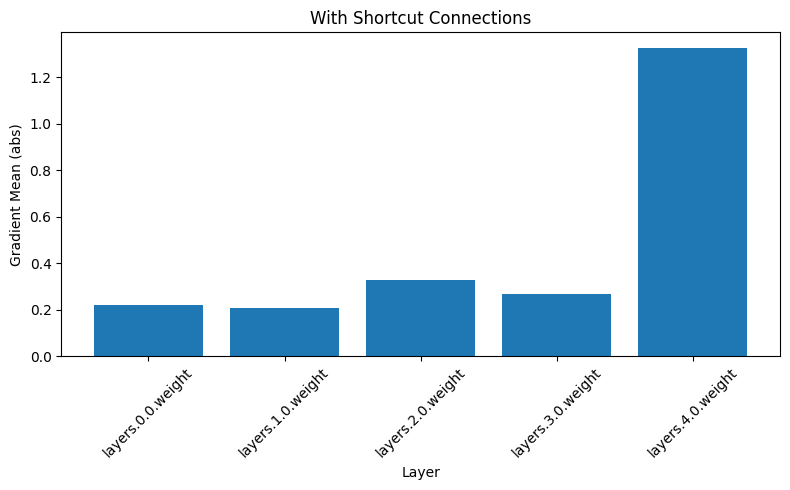

In [47]:
# 기울기 시각화 (쇼트컷 있는는 모델)
plot_gradients(model_with_shortcut, title="With Shortcut Connections")

- 위 출력에서 보듯 쇼트컷 연결을 사용하면 초반 층(`layer.0`)에서 기울기가 사라지지 않습니다. 이 아이디어를 다음 절의 트랜스포머 블록 구현에 적용할 것입니다

## 4.5 트랜스포머 블록에서 어텐션과 선형층 연결하기

- 이제 앞에서 다룬 개념들을 모아 트랜스포머 블록을 구성하겠습니다
- 트랜스포머 블록은 이전 장에서 구현한 인과 멀티헤드 어텐션과, 이번 장에서 구현한 선형층·피드포워드 네트워크를 결합합니다
- 여기에 드롭아웃과 쇼트컷 연결도 함께 사용합니다

In [ ]:
# 로컬에 `previous_chapters.py` 파일이 없으면
# `llms-from-scratch` PyPI 패키지에서 임포트할 수 있습니다.
# 자세한 내용: https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg
# 예시:
# 예: from llms_from_scratch.ch03 import MultiHeadAttention

from previous_chapters import MultiHeadAttention  # 어텐션 모듈 임포트


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 멀티헤드 어텐션 계층 정의
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        # 피드포워드 계층 정의
        self.ff = FeedForward(cfg)
        # 층 정규화 정의
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        # 드롭아웃 레이어 정의 (쇼트컷 후 사용)
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # 어텐션 블록: 입력 x에 norm1 후 어텐션, 드롭아웃, 그리고 쇼트컷 연결
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # 출력: [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # 입력을 다시 더해줌 (Residual/Shortcut 연결)

        # 피드포워드 블록: 위 출력 x에 norm2 후 피드포워드, 드롭아웃, 그리고 쇼트컷 연결
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 입력을 다시 더해줌 (Residual/Shortcut 연결)

        return x

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="800px">

- 예를 들어 토큰이 6개인 입력 샘플 2개가 있고, 각 토큰이 768차원 임베딩 벡터라고 합시다. 그러면 이 트랜스포머 블록은 셀프 어텐션과 선형층을 거쳐 유사한 크기의 출력을 만듭니다
- 출력은 이전 장에서 다룬 컨텍스트 벡터를 확장한 표현이라고 볼 수 있습니다

In [33]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # 형태: [batch_size, num_tokens, emb_dim]
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="800px">

## 4.6 GPT 모델 코딩하기

- 이제 거의 다 왔습니다. 이 장 맨 앞에서 구현한 아키텍처에 트랜스포머 블록을 끼워 넣어 실제로 사용할 수 있는 GPT 구조를 완성해 봅시다
- 트랜스포머 블록은 여러 번 반복되는데, 가장 작은 124M GPT-2 모델에서는 12번 반복합니다:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="800px">

- `cfg["n_layers"] = 12`일 때의 코드 구현은 다음과 같습니다:

In [ ]:
# GPT 모델 클래스 정의 (nn.Module 상속)
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # 토큰 임베딩 레이어: 각 토큰 인덱스를 임베딩 벡터로 변환
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        # 위치 임베딩 레이어: 각 토큰 위치에 대한 임베딩 벡터 생성
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        # 임베딩 이후 드롭아웃 적용
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        # 트랜스포머 블록 여러 개를 순차적으로 쌓음
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        # 최종 layer normalization
        self.final_norm = LayerNorm(cfg["emb_dim"])
        # 출력층: 마지막 임베딩을 어휘 집합 크기로 매핑 (softmax 이전 단계)
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        # 입력 크기: [배치 크기, 시퀀스 길이]
        batch_size, seq_len = in_idx.shape
        # 토큰 임베딩: 입력 토큰을 임베딩 벡터로 변환
        tok_embeds = self.tok_emb(in_idx)
        # 위치 임베딩: 0~(시퀀스 길이-1)까지 위치에 해당하는 임베딩
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        # 임베딩 합성: 각 토큰 벡터 + 위치 벡터
        x = tok_embeds + pos_embeds  # 형태: [batch_size, num_tokens, emb_size]
        # 드롭아웃 적용
        x = self.drop_emb(x)
        # 트랜스포머 블록 통과
        x = self.trf_blocks(x)
        # layer normalization 적용
        x = self.final_norm(x)
        # 출력층을 통해 예측값 (로짓) 생성
        logits = self.out_head(x)
        # 로짓 반환 ([배치, 시퀀스, 어휘집합] shape)
        return logits

- 124M 파라미터 구성으로 GPT 모델을 초기 무작위 가중치와 함께 생성하면 다음과 같습니다:

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


- 이 모델은 다음 장에서 학습시킬 예정입니다
- 다만 크기에 대해 다시 한번 짚고 넘어가겠습니다. 앞서 124M 파라미터 모델이라고 했는데, 실제로는 얼마나 되는지 확인해 봅시다:

In [36]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 위 결과를 보면 모델 파라미터 수가 124M이 아니라 163M입니다. 왜 그럴까요?
- 원래 GPT-2 논문에서는 토큰 임베딩 층(`tok_emb`)을 출력층과 공유하는 가중치 결합(weight tying)을 적용했습니다. 즉 `self.out_head.weight = self.tok_emb.weight`로 설정합니다
- 토큰 임베딩 층은 50,257차원 원-핫 입력을 768차원 임베딩으로 투영합니다
- 출력층은 768차원 임베딩을 다시 50,257차원 표현으로 투영해 단어를 복원합니다(자세한 내용은 다음 절에서 다룹니다)
- 두 층의 가중치 행렬 형태가 같기 때문에 파라미터 수도 동일합니다
- 따라서 출력층의 파라미터를 빼 주면 124M 파라미터 모델과 일치하게 됩니다

In [37]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- GPT-2 논문에서는 토큰 임베딩 행렬을 그대로 출력 행렬로 재사용했습니다
- 따라서 출력층 파라미터 수를 빼면 124M 파라미터 모델 크기가 됩니다:

In [38]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- 실제 학습에서는 가중치를 묶지 않는 편이 더 다루기 쉬워서 여기서는 적용하지 않았습니다
- 하지만 5장에서 사전 학습된 가중치를 불러올 때는 이 weight tying 아이디어를 다시 적용할 예정입니다
- 마지막으로 모델의 메모리 요구량을 계산해 두면 참고하기 좋습니다:

In [39]:
# 총 바이트 수 계산(float32 기준, 파라미터당 4바이트 가정)
total_size_bytes = total_params * 4

# 메가바이트 단위로 변환
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


- 연습: [GPT-2 논문](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C)에 나온 다른 구성도 시도해 보세요.

    - **GPT2-small** (이번에 구현한 124M 구성)
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16

    - **GPT2-large**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20

    - **GPT2-XL**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 텍스트 생성하기

- 앞에서 구현한 GPT 모델 같은 LLM은 한 번에 하나의 단어(토큰)를 생성합니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="800px">

- 아래 `generate_text_simple` 함수는 그리디 디코딩(greedy decoding)을 구현한 것으로, 간단하고 빠르게 텍스트를 생성할 수 있습니다
- 그리디 디코딩에서는 매 단계마다 확률이 가장 높은 단어(또는 토큰)를 다음 출력으로 선택합니다. 가장 큰 로그확률(logit)이 가장 높은 확률에 대응하므로, 엄밀히는 softmax를 계산하지 않아도 됩니다
- 다음 장에서는 더 발전된 `generate_text` 함수를 구현할 예정입니다
- 아래 그림은 입력 컨텍스트가 주어졌을 때 GPT 모델이 다음 단어 토큰을 생성하는 과정을 보여 줍니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="800px">

In [40]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx는 현재 컨텍스트에서 (batch, n_tokens) 형태의 토큰 인덱스 배열
    for _ in range(max_new_tokens):
        
        # 컨텍스트 길이를 초과하면 지원되는 길이에 맞게 뒤쪽만 남깁니다
        # 예: LLM이 5개 토큰만 지원하고 현재 컨텍스트가 10개라면
        # 마지막 5개 토큰만 컨텍스트로 사용합니다
        idx_cond = idx[:, -context_size:]
        
        # 예측값 계산
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 마지막 타임스텝에만 집중
        # (batch, n_tokens, vocab_size)가 (batch, vocab_size)로 변환
        logits = logits[:, -1, :]  

        # softmax를 적용해 확률 계산
        probas = torch.softmax(logits, dim=-1)  # 형태: (batch, vocab_size)

        # 확률이 가장 높은 어휘 인덱스 선택
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # 형태: (batch, 1)

        # 선택한 인덱스를 시퀀스 끝에 추가
        idx = torch.cat((idx, idx_next), dim=1)  # 형태: (batch, n_tokens+1)

    return idx

- 위 `generate_text_simple` 함수는 한 번에 하나의 토큰을 생성하는 반복 과정을 구현합니다

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="800px">

- 입력 예시를 준비해 보겠습니다:

In [ ]:
# 시작 문장을 정의합니다.
start_context = "Hello, I am"

# 시작 문장을 토크나이저를 이용해 정수 인덱스로 변환합니다.
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

# 파이토치 텐서로 변환 후 배치 차원을 추가합니다.
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
# 드롭아웃(dropout)을 비활성화하여 추론 모드로 전환합니다.
model.eval() 

# generate_text_simple 함수를 사용하여 텍스트를 생성합니다.
# 입력:
#   - model: 사용할 GPT 모델
#   - idx: 시작 시퀀스(토큰 인덱스, 텐서 형태)
#   - max_new_tokens: 생성할 토큰 개수 (6개)
#   - context_size: 모델의 컨텍스트 윈도우 크기(GPT_CONFIG_124M에서 가져옴)
out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

# 생성된 텍스트 인덱스 출력
print("Output:", out)
# 출력 시퀀스의 길이 출력
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- 배치 차원을 제거하고 텍스트로 다시 변환합니다:

In [43]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- 아직 학습되지 않은 모델이므로 위와 같이 무작위에 가까운 문장이 출력됩니다
- 이 모델은 다음 장에서 학습시킬 예정입니다

## 요약 및 핵심 포인트

- [./gpt.py](./gpt.py) 스크립트에는 이 노트북에서 구현한 GPT 모델이 독립적으로 정리되어 있습니다
- 연습 문제 해설은 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에서 확인할 수 있습니다